# fast transfer learning with PyTorch

## import libraries

In [1]:
# . . import libraries
import sys,os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.preprocessing import StandardScaler
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style
#style.use('dark_background')
# . . to see the available options
# print(plt.style.available)
from glob import glob
import imageio
from torchsummary import summary

# . . import libraries by tugrulkonuk
import utils
from utils import forward_pass
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 10
    # . . the learning rate 
    lr = 0.001

    # . . batch_size
    batch_size = 64

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.0005

    # . . patience for early stopping
    patience = 10

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## download the data


In [5]:
# . . the Food-5K dataset is available at: https://mmspg.epfl.ch/downloads/food-image-datasets/
# . . contains 2500 food and 2500 nonfood images for food/non-doof classification
# . . the naming convention for hte data
# . . {ClassID}_{ImageID}.jpg where ClassID: 0 or 1; 0 means non-food and 1 means food
# . . uncomment below if not done
#!wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
# --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip

In [6]:
# . . unzip the data 
# . . uncomment below if not done
#!unzip -qq -o Food-5K.zip

In [7]:
# . .prepare the data directiories for torchvision
# . . uncomment below if not done
#!mkdir data
#!mkdir data/train
#!mkdir data/test
#!mkdir data/validation
#!mkdir data/train/nonfood
#!mkdir data/train/food
#!mkdir data/test/nonfood
#!mkdir data/test/food
#!mkdir data/validation/nonfood
#!mkdir data/validation/food

In [8]:
# . . move images to appropriate folders
# . . move non-food training images
# . . uncomment below if not done
#!mv Food-5K/training/0*.jpg data/train/nonfood
#!mv Food-5K/training/1*.jpg data/train/food
#!mv Food-5K/validation/0*.jpg data/validation/nonfood
#!mv Food-5K/validation/1*.jpg data/validation/food
#!mv Food-5K/evaluation/0*.jpg data/test/nonfood
#!mv Food-5K/evaluation/1*.jpg data/test/food

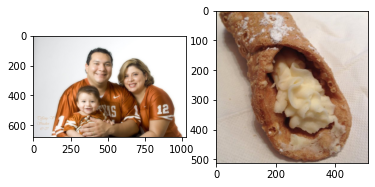

In [9]:
# . . check images
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imageio.imread('data/train/nonfood/0_365.jpg'))
ax2.imshow(imageio.imread('data/train/food/1_365.jpg'))
plt.show()

In [10]:
# . . standard transforms for ImageNet:
# . . normalize with the mean and standard deviation: image = (image - mean) / std
transform = transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [11]:
# . . use the ImageFolder property of torchvision to create dataset objects
# . . the train set
train_dataset = datasets.ImageFolder(
    root='data/train',
    transform=transform)

# . . the validation set
valid_dataset = datasets.ImageFolder(
    root='data/validation',
    transform=transform)

# . . the test set
test_dataset = datasets.ImageFolder(
    root='data/test',
    transform=transform)    

## data loaders

In [12]:
# . . the training loader: shuffle
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the validation loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
testloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)                         

In [13]:
# . . define the pretrained model to be used for the transfer learning
vgg = models.vgg16(pretrained=True)

In [14]:
# . . the VGG operations are separate from the rest of the network
class VGGFeatures(nn.Module):
    # . .constructors just saves the vgg model
    def __init__(self, vgg):
        super(VGGFeatures, self).__init__()
        self.vgg = vgg

    # . . pass the input through the VGG network
    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        # . . flatten the output for the logistic regression
        x = x.view(x.size(0), -1)
        
        return x

In [15]:
# . . create the vgg features class
vggf = VGGFeatures(vgg)


In [16]:
# . . forward pass the data to the VGG network
# . . the idea is that instead of running multiple (expensive) forward passes 
# . . of the vgg network, we just do it once and use the output as the input 
# . . for the logistic regression network
# . . number of training, validation, and test images
num_train = len(train_dataset)
num_valid = len(valid_dataset)
num_test  = len(test_dataset)

# . .  compute the output shape of the VGG network: run on a single image (array)
dim_vgg = vggf(torch.rand(1, 3, 224, 224)).shape[1]

# . . send VGG network to device
vggf.to(device)

VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [17]:
# . . pass training, validation, and test datasets trough the pretrained VGG network
X_train, y_train = forward_pass(vggf, trainloader, num_train, dim_vgg, device)
X_valid, y_valid = forward_pass(vggf, validloader, num_valid, dim_vgg, device)
X_test , y_test  = forward_pass(vggf, testloader , num_test , dim_vgg, device)


In [18]:
# . . scale the data for the logistic regression
# . . output VGG values are high because of the ReLU activation

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test  = scaler.fit_transform(X_test)

In [19]:
# . . create new datasets using VGG outputs
# . . overwrite the precious ones
training_dataset = data.TensorDataset(
    torch.from_numpy(X_train.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32)))

valid_dataset = data.TensorDataset(
    torch.from_numpy(X_valid.astype(np.float32)),
    torch.from_numpy(y_valid.astype(np.float32)))    

test_dataset = data.TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32)))        

In [20]:
# . . new data loaders for VGG outputs
# . . the training loader: shuffle
trainloader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the validation loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
testloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)                         

In [21]:
# . . the logistic regression model in pytorch
model = nn.Linear(dim_vgg, 1)

# . . send the model to device
model.to(device)

Linear(in_features=25088, out_features=1, bias=True)

In [22]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = nn.BCEWithLogitsLoss()

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(), EarlyStopping(min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':50,
                   'threshold':1e-5,
                   'cooldown':5,
                   'min_lr':1e-5,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


In [23]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, scheduler=None, num_epochs=num_epochs)

Training started:  January 20, 2021 - 11:57AM
Epoch:     0	Train Loss: 0.080073	Valid Loss: 0.044273	Elapsed time: 0:00:00.669184
Epoch:     1	Train Loss: 0.004071	Valid Loss: 0.042580	Elapsed time: 0:00:00.663749
Epoch:     2	Train Loss: 0.000802	Valid Loss: 0.040760	Elapsed time: 0:00:00.671216
Epoch:     3	Train Loss: 0.000490	Valid Loss: 0.040270	Elapsed time: 0:00:00.732627
Epoch:     4	Train Loss: 0.000380	Valid Loss: 0.039775	Elapsed time: 0:00:00.664402
Epoch:     5	Train Loss: 0.000312	Valid Loss: 0.039559	Elapsed time: 0:00:00.773396
Epoch:     6	Train Loss: 0.000262	Valid Loss: 0.039221	Elapsed time: 0:00:00.713155
Epoch:     7	Train Loss: 0.000224	Valid Loss: 0.039074	Elapsed time: 0:00:00.640599
Epoch:     8	Train Loss: 0.000196	Valid Loss: 0.038841	Elapsed time: 0:00:00.648796
Epoch:     9	Train Loss: 0.000172	Valid Loss: 0.038689	Elapsed time: 0:00:00.651167
Training finished:  January 20, 2021 - 11:58AM
Best Loss: 0.038689	Epoch:     9


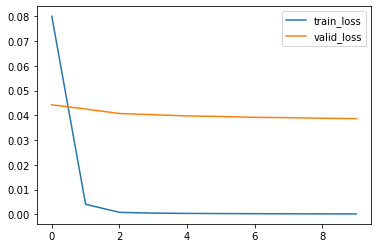

In [24]:
# . . plot the training and validation losses
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

In [25]:
# . . evaluate the accuracy of the trained network
training_accuracy, test_accuracy = trainer.evaluate(trainloader, testloader)

Training accuracy: 1.0000, Test accuracy: 0.9890
